Will create data for days 0-750 then fit a forecaster on it to predict logReturns and then export the model and attempt to runin a sim without retraining.

In [2]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.plot import set_dark_theme
from tqdm import tqdm

import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning

import warnings

In [3]:
prices1000Days = np.loadtxt("../../sourceCode/1000Prices.txt").T

from strategies.ms_forecasting.main import createGreeksManager
from strategies.ms_forecasting.main import GreeksManager
from strategies.ms_forecasting.main import PRICE_LAGS
from strategies.ms_forecasting.main import MOMENTUM_WINDOWS
from strategies.ms_forecasting.main import VOL_WINDOWS

preTrainingDays = max(PRICE_LAGS + MOMENTUM_WINDOWS + VOL_WINDOWS)

trainingDataWindowSize = 750 - preTrainingDays # 20 days of data needed for all greeks to be void of NaN's
gm: GreeksManager = createGreeksManager(prices1000Days[:, :751], trainingDataWindowSize) # giving 751 days but the 751'st is removed when we get the history

exogIndex = pd.RangeIndex(preTrainingDays, 750)
exogDict = gm.getGreeksHistoryDict(exogIndex)

print("Inst 0 days [742, 750]:\n", prices1000Days[0, 742:750])
display("inst 0 head:", exogDict["inst_0"].tail(1))
print(f"each inst-greek has {len(exogDict["inst_0"]["greek_lag_1"])} days")

Inst 0 days [742, 750]:
 [36.81 36.75 36.53 36.49 36.3  36.58 36.43 36.24]


'inst 0 head:'

,greek_lag_1,greek_lag_2,greek_lag_3,greek_lag_4,greek_lag_5,greek_lag_6,greek_lag_7,greek_volatility_5,greek_volatility_10,greek_volatility_20,greek_momentum_3,greek_momentum_7,greek_momentum_14,greek_price
749,36.43,36.58,36.3,36.49,36.53,36.75,36.81,0.005455,0.004396,0.00372,-0.001654,-0.015606,-0.028562,36.24


each inst-greek has 730 days


In [4]:
logReturnsPricesWindow = prices1000Days[:, preTrainingDays:]
logReturnsNp = np.log(logReturnsPricesWindow[:, 1:] / logReturnsPricesWindow[:, :-1])

logReturnsIndex = pd.RangeIndex(preTrainingDays, 999)
logReturnsSeries = pd.DataFrame(logReturnsNp.T,
                          index = logReturnsIndex,
                          columns = [f"inst_{i}" for i in range(logReturnsNp.shape[0])])

logReturnsTrainingSeries = logReturnsSeries.iloc[:trainingDataWindowSize]

In [5]:
logReturnsForecaster = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523,
                                                        learning_rate=0.05),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags                = 7,
    window_features     = RollingFeatures(
                                stats           = ['min', 'max', 'ewm'],
                                window_sizes    = 7,
                            ),
)

logReturnsForecaster.fit(
    series  = logReturnsTrainingSeries,
    exog    = exogDict
)

logReturnsForecaster.is_fitted

True

In [6]:
display(logReturnsTrainingSeries.tail(1))
display(exogDict["inst_0"].tail(1))

,inst_0,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,...,inst_40,inst_41,inst_42,inst_43,inst_44,inst_45,inst_46,inst_47,inst_48,inst_49
749,-0.001104,0.0,-0.009485,-0.010395,-0.003002,0.002784,0.002259,-0.008953,-0.007064,0.009198,...,0.0028,0.010673,-0.018626,-0.01809,-0.00267,0.001937,-0.006005,0.010743,-0.002986,-0.003171


,greek_lag_1,greek_lag_2,greek_lag_3,greek_lag_4,greek_lag_5,greek_lag_6,greek_lag_7,greek_volatility_5,greek_volatility_10,greek_volatility_20,greek_momentum_3,greek_momentum_7,greek_momentum_14,greek_price
749,36.43,36.58,36.3,36.49,36.53,36.75,36.81,0.005455,0.004396,0.00372,-0.001654,-0.015606,-0.028562,36.24


# Simulate updating the greeks daily and making a one step prediction:

In [10]:
predictions = []

for day in range(750, 1000):
    gm.updateGreeks(prices1000Days[:, day])

    currentDayIndex = pd.RangeIndex(start=day, stop=day + 1)
    predictionExogs = gm.getGreeksDict(currentDayIndex)
    logReturnsPredictionSeries = logReturnsSeries.iloc[:day - preTrainingDays].tail(7)

    prediction = logReturnsForecaster.predict(
        last_window = logReturnsPredictionSeries,
        exog        = predictionExogs,
        steps       = 1,
        levels      = list(logReturnsSeries.columns),
    )

    predictions.append(prediction["pred"].values)

instrumentPredictions shape = (250,)
actualInstrumentLogReturns shape = (250,)


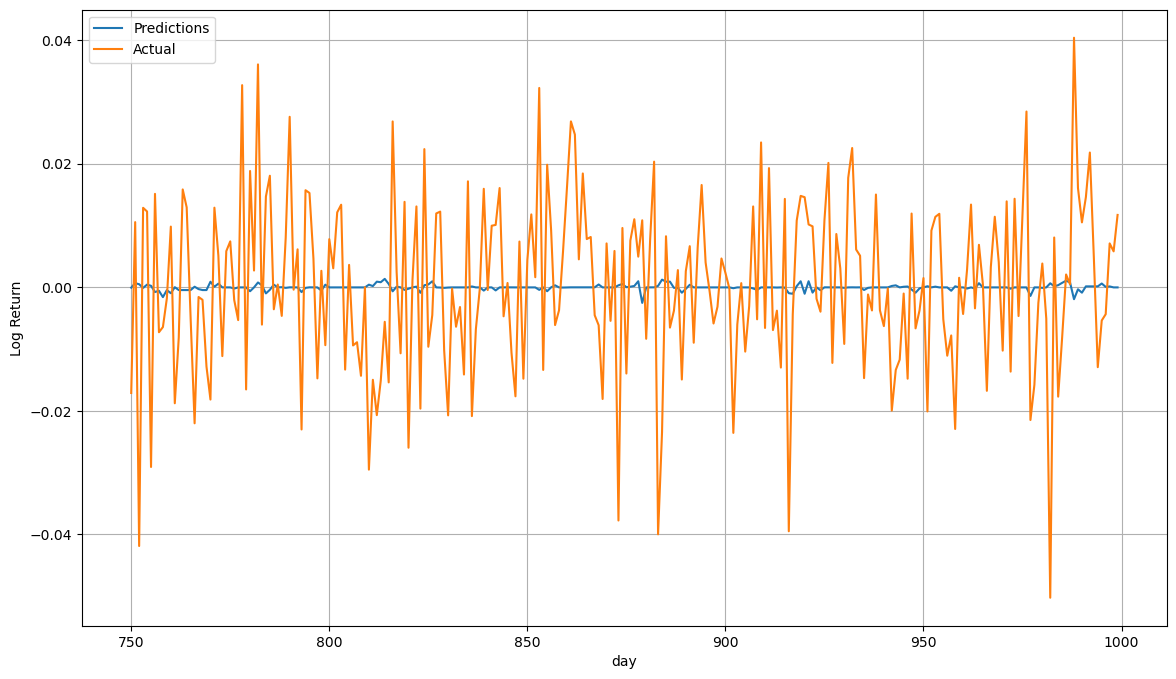

In [18]:
def plotPredictedVsActualLogReturns(predictions, actualLogReturns, instrumentIndex):
    instrumentPredictions = np.array([prediction[instrumentIndex] for prediction in predictions])
    actualInstrumentLogReturns = actualLogReturns[instrumentIndex, :]

    print(f"instrumentPredictions shape = {instrumentPredictions.shape}")
    print(f"actualInstrumentLogReturns shape = {actualInstrumentLogReturns.shape}")

    days = np.arange(750, 1000)

    plt.figure(figsize=(14, 8))
    plt.plot(days, instrumentPredictions, label = "Predictions")
    plt.plot(days, actualInstrumentLogReturns, label = "Actual")
    plt.xlabel("day")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

actualLogReturns = np.log(prices1000Days[:, 750:] / prices1000Days[:, 749:-1])

plotPredictedVsActualLogReturns(predictions, actualLogReturns, 37)